# Hybrid Model for Diabetic Retinopathy Diagnosis & Classification

This notebook focuses on developing a **hybrid deep learning model** to diagnose and classify **diabetic retinopathy (DR) stages** from retinal images.

# 📌 Dataset Loading & Visualization

This cell performs the **initial dataset setup** by mounting Google Drive, accessing the dataset, listing categories, counting images, and displaying sample images.

Mounted at /content/drive
Available categories: ['Severe', 'Moderate', 'Mild', 'Proliferate_DR', 'No_DR']
Category: Severe, Number of images: 193
Category: Moderate, Number of images: 999
Category: Mild, Number of images: 370
Category: Proliferate_DR, Number of images: 708
Category: No_DR, Number of images: 1805


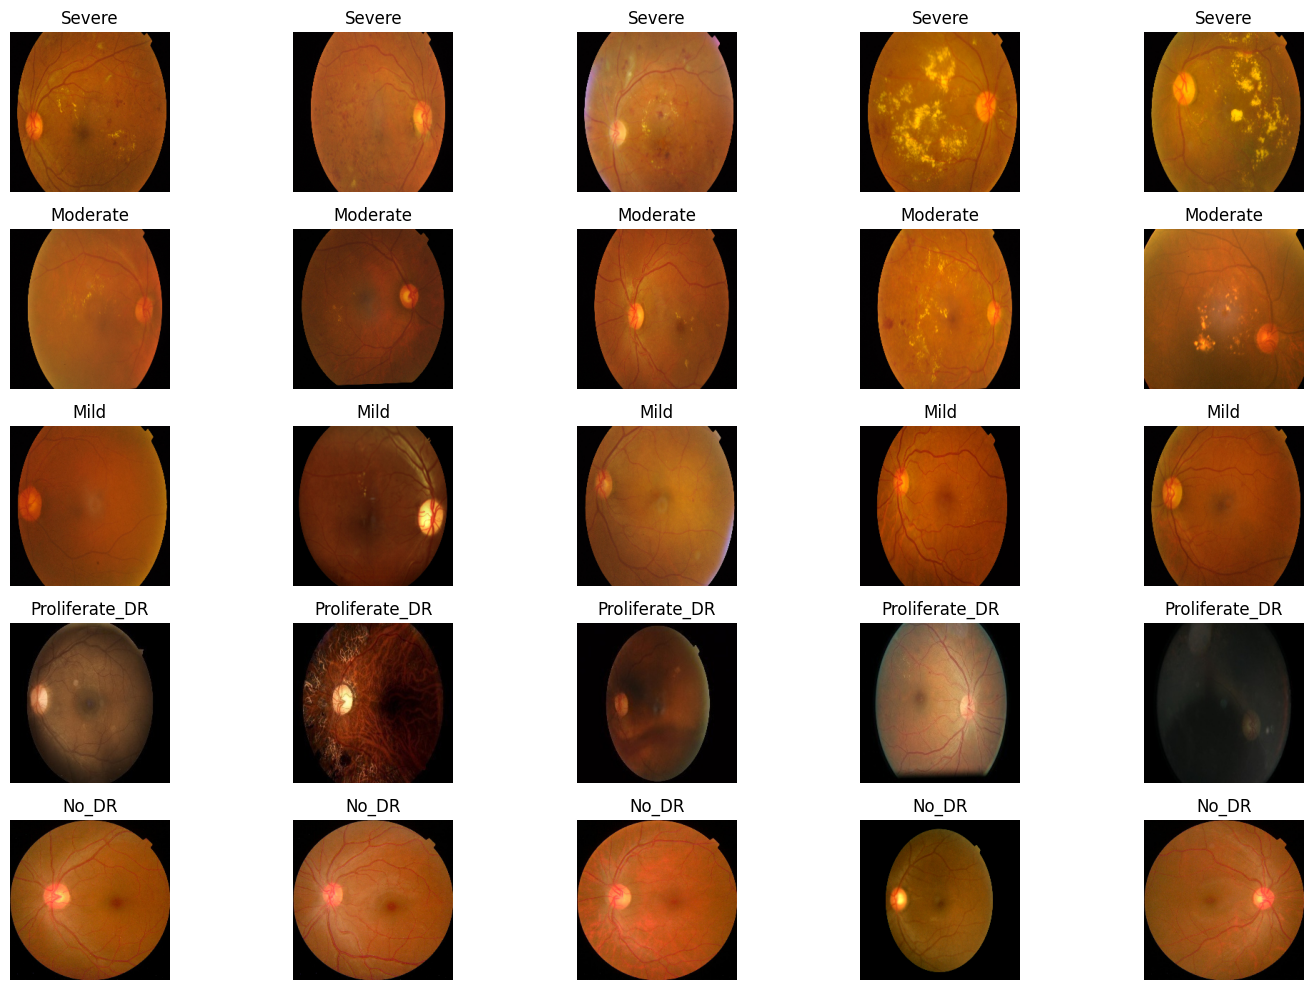

In [ ]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
from PIL import Image

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

# Path to the dataset
data_path = "/content/drive/My Drive/colored_images"

# List the folders in the dataset
categories = os.listdir(data_path)
print("Available categories:", categories)

# Count images in each category
for category in categories:
    category_path = os.path.join(data_path, category)
    images = os.listdir(category_path)
    print(f"Category: {category}, Number of images: {len(images)}")

def display_sample_images(data_path, categories, num_images=5):
    """
    Display a sample of images from each category
    """
    plt.figure(figsize=(15, 10))
    for i, category in enumerate(categories):
        category_path = os.path.join(data_path, category)
        images = os.listdir(category_path)

        for j in range(min(num_images, len(images))):
            img_path = os.path.join(category_path, images[j])
            img = Image.open(img_path)

            plt.subplot(len(categories), num_images, i * num_images + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(category)

    plt.tight_layout()
    plt.show()

# Show sample images
display_sample_images(data_path, categories)

# 📏 Image Preprocessing: Resizing Images

This cell ensures **all images are resized** to a fixed dimension of **224x224 pixels**, which is a common input size for deep learning models. The resizing process is necessary to standardize the dataset before training the hybrid model.

In [ ]:
import os
import cv2
from tqdm import tqdm

# Target dimensions for resizing
target_size = (224, 224)

def resize_images(data_path, categories):
    """
    Resize images in all categories to 224x224 and overwrite the originals.
    """
    for category in tqdm(categories, desc="Resizing Images"):
        category_path = os.path.join(data_path, category)
        images = os.listdir(category_path)

        for img_name in images:
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)  # Read the image
            if img is not None:
                resized_img = cv2.resize(img, target_size)  # Resize the image
                cv2.imwrite(img_path, resized_img)  # Overwrite the original


resize_images(data_path, categories)

Resizing Images: 100%|██████████| 5/5 [01:54<00:00, 22.87s/it]


# 🖼️ Verify Resized Images

This cell **visualizes the resized images** to ensure that they were correctly processed and now conform to the **224x224 resolution**.

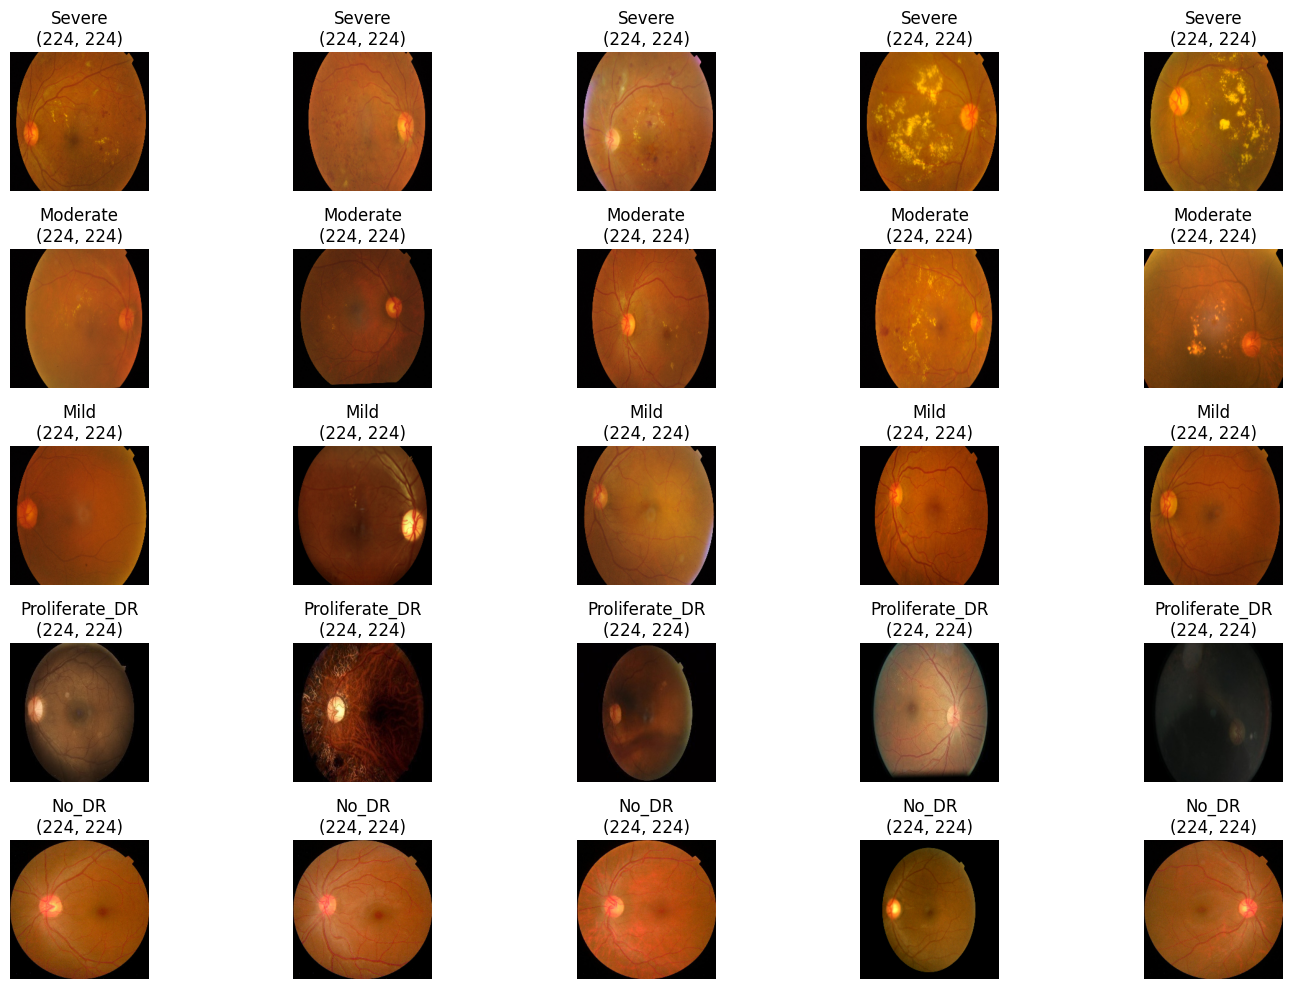

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def display_resized_images(data_path, categories, num_images=5):
    """
    Display samples of resized images for each category.
    """
    plt.figure(figsize=(15, 10))
    for i, category in enumerate(categories):
        category_path = os.path.join(data_path, category)
        images = os.listdir(category_path)

        for j in range(min(num_images, len(images))):
            img_path = os.path.join(category_path, images[j])
            img = Image.open(img_path)

            plt.subplot(len(categories), num_images, i * num_images + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{category}\n{img.size}")  # Show dimensions

    plt.tight_layout()
    plt.show()

# Call the function to display resized images
display_resized_images(data_path, categories)

# 🔎 Image Preprocessing: Enhancing Image Quality

This cell applies **image enhancement techniques** to improve the quality of retinal images before training the hybrid model. The goal is to enhance image contrast, reduce noise, and sharpen details to make the model more effective in diagnosing **diabetic retinopathy**.

Processing Categories: 100%|██████████| 5/5 [01:07<00:00, 13.56s/it]


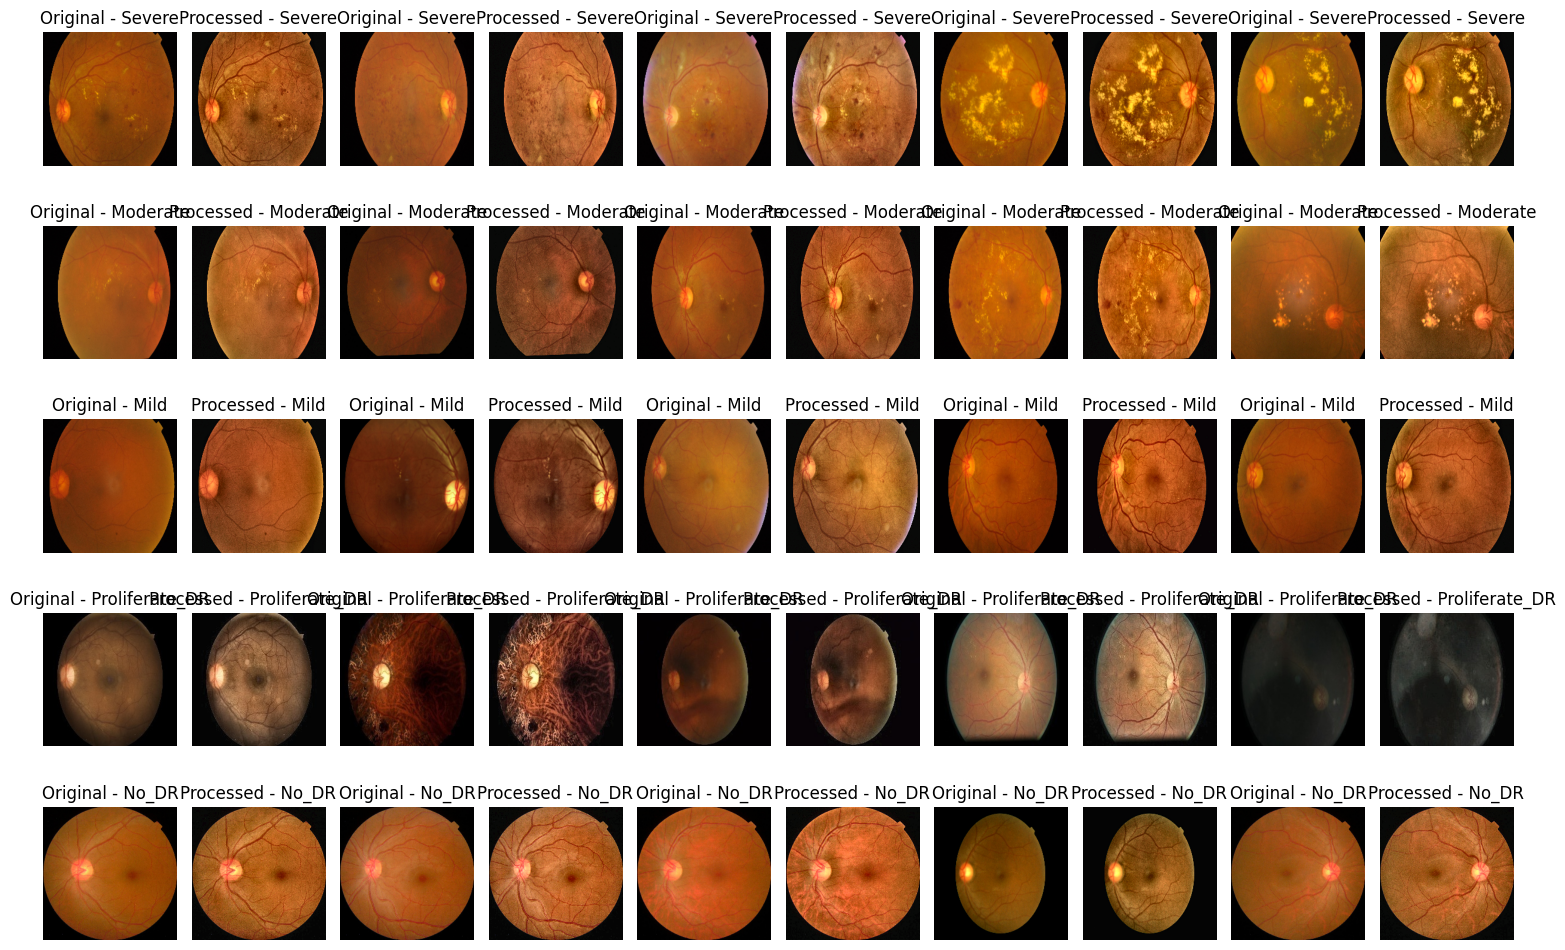

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# Path to save processed images
processed_data_path = os.path.join(data_path, "processed_images")
os.makedirs(processed_data_path, exist_ok=True)

def preprocess_image(img_path):
    """
    Improve image quality using:
    1. CLAHE for contrast enhancement.
    2. Gaussian Blur to reduce noise.
    3. Unsharp Mask to enhance details.
    """
    img = cv2.imread(img_path)  # Read the image
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # Convert to LAB color space
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the lightness channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    # Merge channels back
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # Apply Gaussian Blur
    img_blur = cv2.GaussianBlur(img_clahe, (3, 3), 0)

    # Apply Unsharp Mask
    img_sharp = cv2.addWeighted(img_clahe, 1.5, img_blur, -0.5, 0)

    return img_sharp

# Process and save improved images
for category in tqdm(categories, desc="Processing Categories"):
    category_path = os.path.join(data_path, category)
    processed_category_path = os.path.join(processed_data_path, category)
    os.makedirs(processed_category_path, exist_ok=True)

    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        processed_img_path = os.path.join(processed_category_path, img_name)

        processed_img = preprocess_image(img_path)
        cv2.imwrite(processed_img_path, processed_img)  # Save processed image

def display_processed_images(original_data_path, processed_data_path, categories, num_images=5):
    plt.figure(figsize=(15, 10))
    for i, category in enumerate(categories):
        original_category_path = os.path.join(original_data_path, category)
        processed_category_path = os.path.join(processed_data_path, category)
        original_images = os.listdir(original_category_path)
        processed_images = os.listdir(processed_category_path)

        for j in range(min(num_images, len(original_images), len(processed_images))):
            original_img_path = os.path.join(original_category_path, original_images[j])
            processed_img_path = os.path.join(processed_category_path, processed_images[j])

            original_img = Image.open(original_img_path)
            processed_img = Image.open(processed_img_path)

            # Display original image
            plt.subplot(len(categories), num_images * 2, i * num_images * 2 + j * 2 + 1)
            plt.imshow(original_img)
            plt.axis('off')
            plt.title(f"Original - {category}")

            # Display processed image
            plt.subplot(len(categories), num_images * 2, i * num_images * 2 + j * 2 + 2)
            plt.imshow(processed_img)
            plt.axis('off')
            plt.title(f"Processed - {category}")

    plt.tight_layout()
    plt.show()

# Display original and processed images
display_processed_images(data_path, processed_data_path, categories)

# 🗂️ Splitting Dataset into Training & Testing Sets

This cell splits the **preprocessed dataset** into **training (80%) and testing (20%)** sets to prepare for model training and evaluation.

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths for train and test directories
train_path = os.path.join(processed_data_path, "train")
test_path = os.path.join(processed_data_path, "test")

# Create train and test directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Split data into train and test sets
for category in categories:
    category_path = os.path.join(processed_data_path, category)
    images = os.listdir(category_path)

    # Split images into 80% train and 20% test
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Create subdirectories for each category in train and test
    train_category_path = os.path.join(train_path, category)
    test_category_path = os.path.join(test_path, category)

    os.makedirs(train_category_path, exist_ok=True)
    os.makedirs(test_category_path, exist_ok=True)

    # Copy images to train and test directories
    for img in train_imgs:
        shutil.copy(os.path.join(category_path, img), os.path.join(train_category_path, img))

    for img in test_imgs:
        shutil.copy(os.path.join(category_path, img), os.path.join(test_category_path, img))

    print(f"Images split for category {category}:")
    print(f" - Train: {len(train_imgs)} images")
    print(f" - Test: {len(test_imgs)} images")

# Check the distribution of images in train and test sets
def check_split_distribution(data_path):
    for split in ["train", "test"]:
        split_path = os.path.join(data_path, split)
        print(f"\nTotal images in {split} set:")
        for category in os.listdir(split_path):
            category_path = os.path.join(split_path, category)
            print(f" - {category}: {len(os.listdir(category_path))} images")

check_split_distribution(processed_data_path)


Images split for category Severe:
 - Train: 154 images
 - Test: 39 images
Images split for category Moderate:
 - Train: 799 images
 - Test: 200 images
Images split for category Mild:
 - Train: 296 images
 - Test: 74 images
Images split for category Proliferate_DR:
 - Train: 566 images
 - Test: 142 images
Images split for category No_DR:
 - Train: 1444 images
 - Test: 361 images

Total images in train set:
 - Severe: 154 images
 - Moderate: 799 images
 - Mild: 296 images
 - Proliferate_DR: 566 images
 - No_DR: 1444 images

Total images in test set:
 - Severe: 39 images
 - Moderate: 200 images
 - Mild: 74 images
 - Proliferate_DR: 142 images
 - No_DR: 361 images


# 🖼️ Data Augmentation for Imbalanced Categories

This cell **balances the dataset** by applying **image augmentation** to underrepresented categories. The goal is to ensure that all categories have a similar number of training images, improving model generalization.

In [ ]:
import pandas as pd
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image

# Read data from the training path
train_data_path = os.path.join(processed_data_path, "train")
categories = os.listdir(train_data_path)

# Determine the largest category size
category_sizes = {category: len(os.listdir(os.path.join(train_data_path, category))) for category in categories}
max_category = max(category_sizes.values())
target_size = max_category + 1000  # Target size for all categories

print(f"Largest category has {max_category} images. All categories will be increased to {target_size} images.")

# Set up default and strong augmentation configurations
default_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

strong_datagen = ImageDataGenerator(
    rotation_range=45,  # Larger rotation
    width_shift_range=0.4,  # Larger shift
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,  # Vertical flip for underrepresented classes
    fill_mode="nearest"
)

# Augment data and save it
augmented_data = []

for category in categories:
    category_path = os.path.join(train_data_path, category)
    images = os.listdir(category_path)
    category_size = len(images)

    print(f"\nApplying augmentation for category {category} (current size: {category_size})...")

    # Select augmentation type based on category
    datagen = strong_datagen if category in ["Proliferate_DR", "Severe"] else default_datagen

    # If the category size is smaller than the target
    if category_size < target_size:
        original_images = [os.path.join(category_path, img) for img in images]
        augmented_images = []
        num_to_add = target_size - category_size  # Number of images to add

        # Perform augmentation to reach the target size
        while len(augmented_images) < num_to_add:
            for img_path in original_images:
                try:
                    img = Image.open(img_path).convert("RGB")  # Ensure images are in RGB
                    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                    img_array = np.expand_dims(img_array, axis=0)

                    for batch in datagen.flow(img_array, batch_size=1):
                        aug_img = Image.fromarray((batch[0] * 255).astype(np.uint8))
                        augmented_images.append(aug_img)
                        if len(augmented_images) >= num_to_add:
                            break
                    if len(augmented_images) >= num_to_add:
                        break
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")

        # Save augmented images
        for i, aug_img in enumerate(augmented_images):
            aug_img_path = os.path.join(category_path, f"aug_{i}.png")
            aug_img.save(aug_img_path)
            images.append(f"aug_{i}.png")

    # Update data with augmented images
    augmented_data.extend([(category, img) for img in images])

# Save the augmented data into a CSV file
augmented_df = pd.DataFrame(augmented_data, columns=["Category", "Image"])
augmented_csv_path = os.path.join(processed_data_path, "augmented_data.csv")
augmented_df.to_csv(augmented_csv_path, index=False)

print(f"\nAugmented data saved to: {augmented_csv_path}")

Largest category has 1444 images. All categories will be increased to 2444 images.

Applying augmentation for category Severe (current size: 154)...

Applying augmentation for category Moderate (current size: 799)...

Applying augmentation for category Mild (current size: 296)...

Applying augmentation for category Proliferate_DR (current size: 566)...

Applying augmentation for category No_DR (current size: 1444)...

Augmented data saved to: /content/drive/My Drive/colored_images/processed_images/augmented_data.csv


# 📊 Display Image Count per Category

This cell **prints the number of images in each category** within the training dataset to verify that the augmentation process successfully balanced the dataset.

In [ ]:
import os

# Display the number of images in each category
def display_category_counts(train_data_path):
    categories = os.listdir(train_data_path)
    print("Number of images per category:")
    for category in categories:
        category_path = os.path.join(train_data_path, category)
        num_images = len(os.listdir(category_path))
        print(f"Category {category}: {num_images} images")

# Call the function
display_category_counts(train_data_path)


Number of images per category:
Category Severe: 2444 images
Category Moderate: 2444 images
Category Mild: 2444 images
Category Proliferate_DR: 2444 images
Category No_DR: 2444 images


# 🏥 Preparing Dataset for Training & Testing

This cell **prepares the dataset for PyTorch training** by defining image transformations, creating a custom dataset class, and setting up data loaders for efficient batch processing.

In [ ]:
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Paths for training (after augmentation) and testing data
train_data_path = train_path
test_data_path = test_path

# Define image transformations for data preparation
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.ToTensor(),         # Convert images to tensors
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

# Define a custom dataset
class RetinopathyDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.categories = os.listdir(data_path)
        self.transform = transform
        self.images = []
        self.labels = []

        for idx, category in enumerate(self.categories):
            category_path = os.path.join(data_path, category)
            images = os.listdir(category_path)
            self.images.extend([os.path.join(category_path, img) for img in images])
            self.labels.extend([idx] * len(images))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

# Create DataLoaders for training and testing
train_dataset = RetinopathyDataset(train_data_path, transform=data_transforms["train"])
test_dataset = RetinopathyDataset(test_data_path, transform=data_transforms["test"])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes for verification
print(f"Number of training samples after augmentation: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples after augmentation: 12220
Number of testing samples: 816


# 🤖 Hybrid Model: DenseNet + Vision Transformer (ViT)

This cell defines a **hybrid deep learning model** that combines **DenseNet-121** (a Convolutional Neural Network) with **Vision Transformer (ViT)** to classify **diabetic retinopathy stages**.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import ViTModel, ViTConfig

class HybridDenseNetViT(nn.Module):
    def __init__(self, num_classes=5):
        super(HybridDenseNetViT, self).__init__()

        # Load DenseNet and modify the final layer
        self.densenet = models.densenet121(pretrained=True)
        num_features_densenet = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Identity()  # Remove final classification layer to extract features

        # Load Vision Transformer (ViT)
        vit_config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", config=vit_config)
        vit_hidden_size = vit_config.hidden_size

        # Feature fusion layer
        self.fc = nn.Sequential(
            nn.Linear(num_features_densenet + vit_hidden_size, 512),  # Combine DenseNet and ViT features
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)  # Final classification layer
        )

    def forward(self, x):
        # Extract features using DenseNet
        features_densenet = self.densenet(x)

        # ViT requires images in the shape batch_size x seq_len x patch_dim
        vit_features = self.vit(pixel_values=x).pooler_output

        # Combine features from DenseNet and ViT
        combined_features = torch.cat((features_densenet, vit_features), dim=1)

        # Classify the combined features
        output = self.fc(combined_features)
        return output

# Test the model
if __name__ == "__main__":
    # Set up the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create the model and move it to the device
    num_classes = 5  #
    model = HybridDenseNetViT(num_classes=num_classes).to(device)

    # Test the model with a random input
    dummy_input = torch.randn(8, 3, 224, 224).to(device)  # 8 images of size 224x224x3
    outputs = model(dummy_input)
    print(f"Output shape: {outputs.shape}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 207MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Huggin

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Output shape: torch.Size([8, 5])


# 🚀 Model Training & Evaluation

This cell **trains and evaluates** the **Hybrid DenseNet-ViT** model for **diabetic retinopathy classification**. It includes:
- **Class balancing** to handle dataset imbalance.
- **Training loop** with loss calculation and backpropagation.
- **Evaluation metrics** such as **F1-score, AUC-ROC, accuracy**, and a **confusion matrix**.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
)
import numpy as np
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate class weights to handle class imbalance
def get_class_weights(train_labels):
    class_weights = compute_class_weight("balanced", classes=np.unique(train_labels), y=train_labels)
    return torch.tensor(class_weights, dtype=torch.float).to(device)

# Set up the optimizer and loss function
def get_optimizer_and_criterion(model, train_labels, lr=0.0001):
    class_weights = get_class_weights(train_labels)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return optimizer, criterion

# Compute metrics for evaluation
def calculate_metrics(y_true, y_pred, probs):
    metrics = {
        "F1": f1_score(y_true, y_pred, average="weighted"),
        "Precision": precision_score(y_true, y_pred, average="weighted"),
        "Recall": recall_score(y_true, y_pred, average="weighted"),
        "AUC ROC": roc_auc_score(y_true, probs, multi_class="ovr"),
        "AP": average_precision_score(y_true, probs, average="weighted"),
        "G-Mean": np.sqrt(recall_score(y_true, y_pred, average=None).prod()),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Balanced Accuracy": balanced_accuracy_score(y_true, y_pred),
    }
    return metrics

# Train the model
def train_model(model, train_loader, train_labels, num_epochs=30, lr=0.0001):
    optimizer, criterion = get_optimizer_and_criterion(model, train_labels, lr)
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        all_preds, all_labels, all_probs = [], [], []

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Save outputs
            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            preds = np.argmax(probs, axis=1)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

        # Compute metrics after each epoch
        metrics = calculate_metrics(all_labels, all_preds, np.array(all_probs))
        print(f"\nEpoch {epoch + 1} - Loss: {epoch_loss:.4f}")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

    # Compute final test metrics
    metrics = calculate_metrics(all_labels, all_preds, np.array(all_probs))
    print("\nFinal Test Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Print Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

# Train and evaluate the model
train_labels = [label for _, label in train_loader.dataset]
train_model(model, train_loader, train_labels, num_epochs=30, lr=0.0001)
evaluate_model(model, test_loader)

Epoch 1/30: 100%|██████████| 382/382 [04:52<00:00,  1.31it/s]



Epoch 1 - Loss: 56.1068
F1: 0.9529
Precision: 0.9539
Recall: 0.9527
AUC ROC: 0.9965
AP: 0.9882
G-Mean: 0.8851
Accuracy: 0.9527
Balanced Accuracy: 0.9527


Epoch 2/30: 100%|██████████| 382/382 [04:56<00:00,  1.29it/s]



Epoch 2 - Loss: 30.5484
F1: 0.9710
Precision: 0.9713
Recall: 0.9709
AUC ROC: 0.9986
AP: 0.9951
G-Mean: 0.9283
Accuracy: 0.9709
Balanced Accuracy: 0.9709


Epoch 3/30: 100%|██████████| 382/382 [04:56<00:00,  1.29it/s]



Epoch 3 - Loss: 22.0633
F1: 0.9776
Precision: 0.9777
Recall: 0.9776
AUC ROC: 0.9993
AP: 0.9972
G-Mean: 0.9446
Accuracy: 0.9776
Balanced Accuracy: 0.9776


Epoch 4/30: 100%|██████████| 382/382 [04:56<00:00,  1.29it/s]



Epoch 4 - Loss: 15.6986
F1: 0.9859
Precision: 0.9860
Recall: 0.9859
AUC ROC: 0.9996
AP: 0.9985
G-Mean: 0.9651
Accuracy: 0.9859
Balanced Accuracy: 0.9859


Epoch 5/30: 100%|██████████| 382/382 [04:55<00:00,  1.29it/s]



Epoch 5 - Loss: 12.1676
F1: 0.9878
Precision: 0.9879
Recall: 0.9878
AUC ROC: 0.9997
AP: 0.9990
G-Mean: 0.9697
Accuracy: 0.9878
Balanced Accuracy: 0.9878


Epoch 6/30: 100%|██████████| 382/382 [04:55<00:00,  1.29it/s]



Epoch 6 - Loss: 8.7929
F1: 0.9927
Precision: 0.9927
Recall: 0.9927
AUC ROC: 0.9999
AP: 0.9994
G-Mean: 0.9819
Accuracy: 0.9927
Balanced Accuracy: 0.9927


Epoch 7/30: 100%|██████████| 382/382 [04:52<00:00,  1.30it/s]



Epoch 7 - Loss: 9.4067
F1: 0.9915
Precision: 0.9915
Recall: 0.9915
AUC ROC: 0.9998
AP: 0.9994
G-Mean: 0.9788
Accuracy: 0.9915
Balanced Accuracy: 0.9915


Epoch 8/30: 100%|██████████| 382/382 [04:52<00:00,  1.31it/s]



Epoch 8 - Loss: 5.6053
F1: 0.9954
Precision: 0.9954
Recall: 0.9954
AUC ROC: 0.9999
AP: 0.9998
G-Mean: 0.9886
Accuracy: 0.9954
Balanced Accuracy: 0.9954


Epoch 9/30: 100%|██████████| 382/382 [04:52<00:00,  1.31it/s]



Epoch 9 - Loss: 6.6237
F1: 0.9944
Precision: 0.9944
Recall: 0.9944
AUC ROC: 0.9999
AP: 0.9997
G-Mean: 0.9861
Accuracy: 0.9944
Balanced Accuracy: 0.9944


Epoch 10/30: 100%|██████████| 382/382 [04:52<00:00,  1.31it/s]



Epoch 10 - Loss: 4.6103
F1: 0.9960
Precision: 0.9960
Recall: 0.9960
AUC ROC: 0.9999
AP: 0.9998
G-Mean: 0.9900
Accuracy: 0.9960
Balanced Accuracy: 0.9960


Epoch 11/30: 100%|██████████| 382/382 [04:52<00:00,  1.30it/s]



Epoch 11 - Loss: 3.5555
F1: 0.9970
Precision: 0.9970
Recall: 0.9970
AUC ROC: 1.0000
AP: 0.9999
G-Mean: 0.9924
Accuracy: 0.9970
Balanced Accuracy: 0.9970


Epoch 12/30: 100%|██████████| 382/382 [04:53<00:00,  1.30it/s]



Epoch 12 - Loss: 2.7110
F1: 0.9979
Precision: 0.9979
Recall: 0.9979
AUC ROC: 1.0000
AP: 0.9999
G-Mean: 0.9947
Accuracy: 0.9979
Balanced Accuracy: 0.9979


Epoch 13/30: 100%|██████████| 382/382 [04:52<00:00,  1.30it/s]



Epoch 13 - Loss: 5.4592
F1: 0.9951
Precision: 0.9951
Recall: 0.9951
AUC ROC: 1.0000
AP: 0.9998
G-Mean: 0.9878
Accuracy: 0.9951
Balanced Accuracy: 0.9951


Epoch 14/30: 100%|██████████| 382/382 [04:53<00:00,  1.30it/s]



Epoch 14 - Loss: 6.4772
F1: 0.9937
Precision: 0.9937
Recall: 0.9937
AUC ROC: 0.9999
AP: 0.9997
G-Mean: 0.9843
Accuracy: 0.9937
Balanced Accuracy: 0.9937


Epoch 15/30: 100%|██████████| 382/382 [04:52<00:00,  1.30it/s]



Epoch 15 - Loss: 5.4989
F1: 0.9953
Precision: 0.9953
Recall: 0.9953
AUC ROC: 0.9999
AP: 0.9997
G-Mean: 0.9884
Accuracy: 0.9953
Balanced Accuracy: 0.9953


Epoch 16/30: 100%|██████████| 382/382 [04:53<00:00,  1.30it/s]



Epoch 16 - Loss: 3.0051
F1: 0.9974
Precision: 0.9974
Recall: 0.9974
AUC ROC: 1.0000
AP: 0.9999
G-Mean: 0.9935
Accuracy: 0.9974
Balanced Accuracy: 0.9974


Epoch 17/30: 100%|██████████| 382/382 [04:53<00:00,  1.30it/s]



Epoch 17 - Loss: 3.8770
F1: 0.9961
Precision: 0.9961
Recall: 0.9961
AUC ROC: 1.0000
AP: 0.9999
G-Mean: 0.9902
Accuracy: 0.9961
Balanced Accuracy: 0.9961


Epoch 18/30: 100%|██████████| 382/382 [04:53<00:00,  1.30it/s]



Epoch 18 - Loss: 4.5115
F1: 0.9951
Precision: 0.9951
Recall: 0.9951
AUC ROC: 1.0000
AP: 0.9999
G-Mean: 0.9878
Accuracy: 0.9951
Balanced Accuracy: 0.9951


Epoch 19/30: 100%|██████████| 382/382 [04:53<00:00,  1.30it/s]



Epoch 19 - Loss: 3.5481
F1: 0.9969
Precision: 0.9969
Recall: 0.9969
AUC ROC: 1.0000
AP: 0.9999
G-Mean: 0.9922
Accuracy: 0.9969
Balanced Accuracy: 0.9969


Epoch 20/30: 100%|██████████| 382/382 [04:54<00:00,  1.30it/s]



Epoch 20 - Loss: 1.7788
F1: 0.9980
Precision: 0.9980
Recall: 0.9980
AUC ROC: 1.0000
AP: 1.0000
G-Mean: 0.9949
Accuracy: 0.9980
Balanced Accuracy: 0.9980


Epoch 21/30: 100%|██████████| 382/382 [04:54<00:00,  1.30it/s]



Epoch 21 - Loss: 1.8468
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
AUC ROC: 1.0000
AP: 1.0000
G-Mean: 0.9937
Accuracy: 0.9975
Balanced Accuracy: 0.9975


Epoch 22/30: 100%|██████████| 382/382 [04:54<00:00,  1.30it/s]



Epoch 22 - Loss: 5.5782
F1: 0.9949
Precision: 0.9949
Recall: 0.9949
AUC ROC: 0.9999
AP: 0.9998
G-Mean: 0.9873
Accuracy: 0.9949
Balanced Accuracy: 0.9949


Epoch 23/30: 100%|██████████| 382/382 [04:55<00:00,  1.29it/s]



Epoch 23 - Loss: 3.3076
F1: 0.9967
Precision: 0.9967
Recall: 0.9967
AUC ROC: 1.0000
AP: 0.9999
G-Mean: 0.9918
Accuracy: 0.9967
Balanced Accuracy: 0.9967


Epoch 24/30: 100%|██████████| 382/382 [04:54<00:00,  1.30it/s]



Epoch 24 - Loss: 4.3578
F1: 0.9961
Precision: 0.9961
Recall: 0.9961
AUC ROC: 1.0000
AP: 0.9999
G-Mean: 0.9902
Accuracy: 0.9961
Balanced Accuracy: 0.9961


Epoch 25/30: 100%|██████████| 382/382 [04:54<00:00,  1.30it/s]



Epoch 25 - Loss: 3.0051
F1: 0.9968
Precision: 0.9968
Recall: 0.9968
AUC ROC: 1.0000
AP: 0.9999
G-Mean: 0.9920
Accuracy: 0.9968
Balanced Accuracy: 0.9968


Epoch 26/30: 100%|██████████| 382/382 [04:54<00:00,  1.30it/s]



Epoch 26 - Loss: 3.1385
F1: 0.9962
Precision: 0.9962
Recall: 0.9962
AUC ROC: 1.0000
AP: 0.9999
G-Mean: 0.9906
Accuracy: 0.9962
Balanced Accuracy: 0.9962


Epoch 27/30: 100%|██████████| 382/382 [04:54<00:00,  1.30it/s]



Epoch 27 - Loss: 2.6334
F1: 0.9969
Precision: 0.9969
Recall: 0.9969
AUC ROC: 1.0000
AP: 1.0000
G-Mean: 0.9922
Accuracy: 0.9969
Balanced Accuracy: 0.9969


Epoch 28/30: 100%|██████████| 382/382 [04:54<00:00,  1.30it/s]



Epoch 28 - Loss: 1.1626
F1: 0.9985
Precision: 0.9985
Recall: 0.9985
AUC ROC: 1.0000
AP: 1.0000
G-Mean: 0.9963
Accuracy: 0.9985
Balanced Accuracy: 0.9985


Epoch 29/30: 100%|██████████| 382/382 [04:54<00:00,  1.30it/s]



Epoch 29 - Loss: 1.1030
F1: 0.9983
Precision: 0.9983
Recall: 0.9983
AUC ROC: 1.0000
AP: 1.0000
G-Mean: 0.9957
Accuracy: 0.9983
Balanced Accuracy: 0.9983


Epoch 30/30: 100%|██████████| 382/382 [04:54<00:00,  1.30it/s]



Epoch 30 - Loss: 1.0252
F1: 0.9983
Precision: 0.9983
Recall: 0.9983
AUC ROC: 1.0000
AP: 1.0000
G-Mean: 0.9957
Accuracy: 0.9983
Balanced Accuracy: 0.9983


Evaluating: 100%|██████████| 26/26 [00:08<00:00,  2.96it/s]


Final Test Metrics:
F1: 0.9186
Precision: 0.9200
Recall: 0.9216
AUC ROC: 0.9793
AP: 0.9368
G-Mean: 0.5783
Accuracy: 0.9216
Balanced Accuracy: 0.8245

Confusion Matrix:
[[ 23  15   1   0   0]
 [  5 185   8   0   2]
 [  0  23  46   0   5]
 [  0   0   0 142   0]
 [  0   0   5   0 356]]


# 📊 Visualizing Model Performance with a Confusion Matrix

This cell **evaluates the trained model** and **visualizes its predictions** using a **Confusion Matrix** to analyze misclassifications in diabetic retinopathy classification.

Evaluating: 100%|██████████| 26/26 [00:08<00:00,  2.96it/s]


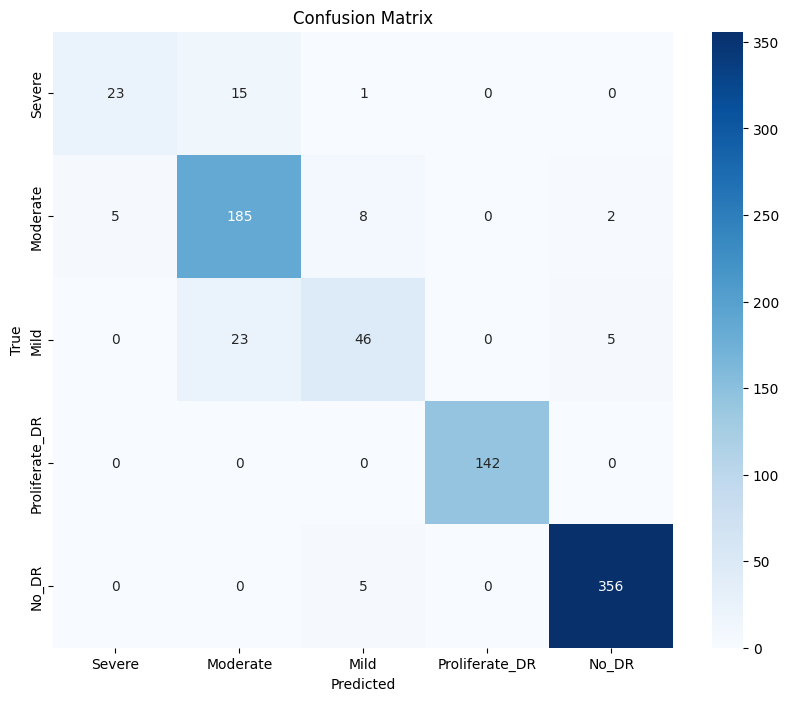

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, categories):
    """
    Plot a visual Confusion Matrix.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate the model and plot the Confusion Matrix
def evaluate_model_with_plot(model, test_loader, categories):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot Confusion Matrix
    plot_confusion_matrix(cm, categories)

# Get category names for the Confusion Matrix
categories = os.listdir(test_data_path)

# Call the evaluation function with visualization
evaluate_model_with_plot(model, test_loader, categories)



# ✅ **Summary of the Notebook**
This notebook successfully implemented a **Hybrid DenseNet-ViT model** for **diabetic retinopathy classification**. The workflow included:

1️⃣ **Dataset Preparation** – Loading, resizing, augmenting, and splitting images into train/test sets.  
2️⃣ **Custom PyTorch Dataset & DataLoaders** – Ensuring efficient batch processing.  
3️⃣ **Hybrid Model Development** – Combining **DenseNet121** (CNN) and **Vision Transformer (ViT)** for robust feature extraction.  
4️⃣ **Model Training & Evaluation** – Using **class-weighted loss**, computing multiple **performance metrics**, and visualizing results with a **Confusion Matrix**.  
5️⃣ **Performance Analysis** – Identifying model strengths & weaknesses for further improvements.  